In [5]:
import sys
import os
import math
from typing import Tuple, Union

import cv2
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from skimage.feature import hog

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from skimage import data, color, exposure


print('Imports successful')


Imports successful


In [3]:
model_path_detect = '/home/jovyan/work/models/blaze_face_short_range.tflite'
model_path_mesh = '/home/jovyan/work/models/face_landmarker.task'

base_options_detect = python.BaseOptions(model_asset_path=model_path_detect)
options_detect = vision.FaceDetectorOptions(base_options=base_options_detect)
detector_detect = vision.FaceDetector.create_from_options(options_detect)

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718358792.719295   18425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718358792.727802   18208 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1718358792.748308   18433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718358792.770234   18436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [4]:
def crop_faces(img_cv2, detection_results, out_path):
    for d in detection_results.detections:  
        bbox = d.bounding_box
        origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
        cropped_img = img_cv2[origin_y:origin_y+height, origin_x:origin_x+width]
        #show_image(cropped_img)      
        cv2.imwrite(str(out_path), cropped_img)
        return cropped_img
    
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title('Face Blendshapes')
  plt.tight_layout()
  plt.show()

# extract landmarks to csv
def extract_and_save_landmarks(c_df, img_cv2, idx):
    rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
    detection_result = detector_mesh.detect(rgb_frame)
    df = pd.DataFrame([(idx, p.name, index, point.x, point.y, point.z) for index, point in enumerate(detection_result.face_landmarks[0])], columns=['image_idx', 'image_name', 'landmark_idx', 'x', 'y', 'z'])
    c_df = c_df.append(df)
    return c_df

In [6]:
# Data paths
EMOREACT = Path('EmoReact')
FER = Path('FER-2013')
KDEF = Path('KDEF-AKDEF')
NIMH = Path('NIMH-CHEFS')

# General paths
BASE_PATH = Path('/home/jovyan/work/data/out')
MODEL_PATH = Path('/home/jovyan/work/models')

# Set dataset here
DATA = NIMH

# Dataset-specific paths
CURRENT_PATH = BASE_PATH / DATA
LABELS = [f.name for f in CURRENT_PATH.iterdir() if f.is_dir()]
IMAGE_PATHS = list(CURRENT_PATH.rglob('*.jpg'))

# Constants for splitting dataset
TRAIN = 'train'
TEST = 'test'
VAL = 'val'

# Feature extraction method
FEATURE = 'pixel'

# Parameters for Histogram of Oriented Gradients (HOG) feature extraction
orientations = 7
pixels_per_cell = 8
cells_per_block = 4

hog_params = { 
    'orientations': orientations,
    'pixels_per_cell': pixels_per_cell,
    'cells_per_block': cells_per_block
}

In [7]:
class Dataset(Dataset):
    def __init__(self, data_path, img_size=64, feature='pixels', transform=None, model_path_mesh='/home/jovyan/work/models/face_landmarker.task', **kwargs):
        self.data_path = Path(data_path)
        self.img_size = img_size
        self.transform = transform

        self.classes = self._get_classes()
        self.image_paths = self._get_image_paths()

        self.hog_args = kwargs
        self.labels = []
        self.data = []
        self.df = pd.DataFrame()

        # mediapipe
        self.model_path_mesh = model_path_mesh
        self.base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
        self.options_mesh = vision.FaceLandmarkerOptions(base_options=self.base_options_mesh, output_face_blendshapes=False, 
                                                         output_facial_transformation_matrixes=True, num_faces=1)
        self.detector_mesh = vision.FaceLandmarker.create_from_options(self.options_mesh)

    
    def __len__(self):
        return len(self.image_paths)
    

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        img_path = self.image_paths[idx]

        if self.transform:
            img = self.transform(img)

        label = Path(img_path).parent.name
        return img, label

    
    def _get_classes(self):
        return [f.name for f in (self.data_path / TRAIN).iterdir() if f.is_dir()]
    

    def _get_image_paths(self):
        paths = list(self.data_path.rglob('*.jpg'))
        random.shuffle( paths )
        return paths
    

    def show_samples(self):
        fig = plt.figure(figsize=(20,20))

        for i in range(10):
            ax = fig.add_subplot(1, 10, i + 1)
            img, label = self.__getitem__(i)
            if img.ndim == 3:
                img = img.squeeze(0)
            img = img.numpy() if isinstance(img, torch.Tensor) else np.array(img)

            ax.imshow(img, cmap='gray')
            ax.set_title(label)
            ax.axis('off')
        plt.show()


    def show_image(self, idx):
        img_cv2 = self.get_cv2_img(idx)
        plt.imshow(img_cv2, cmap='gray')
        plt.show()


    def show_distribution(self):
        labels_count = Counter([self.__getitem__(i)[1] for i in tqdm(range(len(self.image_paths)))])
        sorted_counts = sorted(labels_count.items())
        labels, counts = zip(*sorted_counts)

        plt.figure(figsize=(10, 3))
        bars = plt.bar(labels, counts, color='skyblue')
        plt.xlabel(f'{DATA}')
        plt.ylabel('Count')
        plt.title('Counts per Emotion Category')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, count,
                    ha='center', va='bottom', color='black', fontsize=8) 

        plt.tight_layout()
        plt.show()


    def get_cv2_img(self, idx):
        img_path = self.image_paths[idx]
        return cv2.imread(str(img_path))
    

    def extract_features(self):
        print(f"[INFO] Extracting {self.feature} vectors ...")

        labels = []
        data = []

        for idx in tqdm(range(len(self.dataset))):
            
            img, label = self.dataset[idx]
            img_cv2 = self.dataset.get_cv2_img(idx)

            if self.feature == 'landmarks':

                rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
                detection_result = self.detect(rgb_frame)

                if detection_result.face_landmarks:
                    array = np.array([[lm.x, lm.y, lm.z] for lm in detection_result.face_landmarks[0]]).flatten()
                    labels.append(label)
                    data.append(array)

            elif self.feature == 'pixels':
                        
                labels.append(label)
                img_array = np.array(img)
                data.append(img_array)


            elif self.feature == 'hog':
                
                orientations = self.hog_args.get('orientations', None)
                image_shape = self.hog_args.get('image_shape', None)
                pixels_per_cell = self.hog_args.get('pixels_per_cell', None)
                cells_per_block = self.hog_args.get('cells_per_block', None)

                if orientations is None or image_shape is None or pixels_per_cell is None or cells_per_block is None:
                    raise ValueError("orientations, image_shape, pixels_per_cell and cells_per_block are required for hog feature extraction")

                fd1 = hog(
                    img_cv2, orientations=orientations, 
                    pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                    cells_per_block=(cells_per_block, cells_per_block),
                    block_norm='L2-Hys',
                    transform_sqrt=False, 
                    feature_vector=True
                    )

                labels.append(label)
                data.append(fd1)

            elif self.feature == 'blendshapes':

                rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
                detection_result = self.detector_mesh.detect(rgb_frame)

                if detection_result.face_blendshapes:
                    array = np.array([[bs.index, bs.score] for bs in detection_result.face_blendshapes[0]]).flatten()
                    labels.append(label)
                    data.append(array)
            
            else:
                raise ValueError(f"[Value Error] Unsupported feature type: {self.feature}! Should be one of: [blendshape, pixel, landmark, hog]")
        
        self.data = np.array(data)
        self.labels = np.array(labels)

        return self.data, self.labels


    def to_df(self, to_csv=False):
        df = pd.DataFrame()
        df[FEATURE] = [row for row in self.data.reshape(len(self.dataset), -1)]
        df['emotion'] = [value.item() for value in self.labels.reshape(-1, 1)]
        if to_csv:
            df.to_csv('features.csv')
        return df

In [8]:
feature_extraction_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),

    ])

nimhchefs = Dataset(data_path=CURRENT_PATH, img_size=64, transform=None)

W0000 00:00:1718358853.440472   18208 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1718358853.457196   18585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718358853.474426   18585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


/opt/conda/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


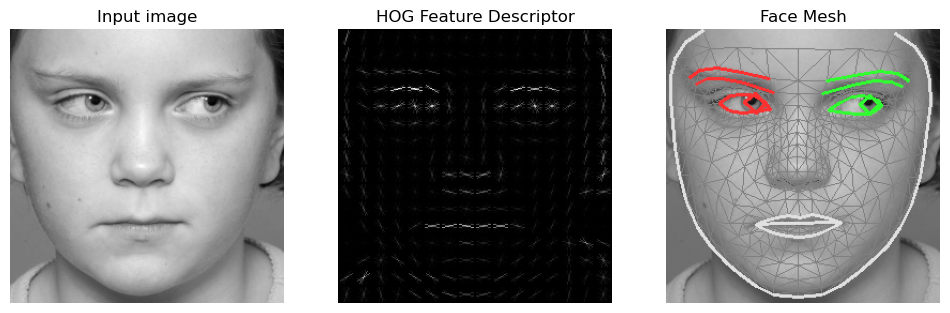

In [9]:

orientations = 8
pixels_per_cell = 16
cells_per_block = 8

img, _ = nimhchefs[0]
img = color.rgb2gray(img)

_, hog_img = hog(
    img, orientations=orientations, 
    pixels_per_cell=(pixels_per_cell, pixels_per_cell),
    cells_per_block=(cells_per_block, cells_per_block),
    block_norm='L2-Hys',
    transform_sqrt=False, 
    visualize=True,
    feature_vector=False
)

image_path = nimhchefs.image_paths[0]
img_cv2 = cv2.imread(str(image_path))
img_mp = mp.Image.create_from_file(str(image_path))

rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
detection_result = detector_mesh.detect(rgb_frame)
annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
mesh_img = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_img, cmap=plt.cm.gray)
ax2.set_title('HOG Feature Descriptor')

ax3.axis('off')
ax3.imshow(mesh_img)
ax3.set_title('Face Mesh')
plt.show()